## Keypoint Detection
---
There are 10 images given in the ***img*** folder. Your task is to detect ***200*** keypoints for each of them using detectors.

Below are the tutorials about SIFT and Harris corners:

SIFT: https://docs.opencv.org/3.4/da/df5/tutorial_py_sift_intro.html

Harris corners: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_features_harris/py_features_harris.html#harris-corners

Let's take a look at these images first!

---

In [1]:
# load packages
import cv2
import numpy as np
import os
import torch
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

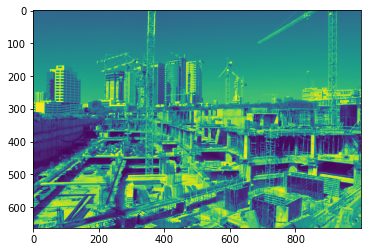

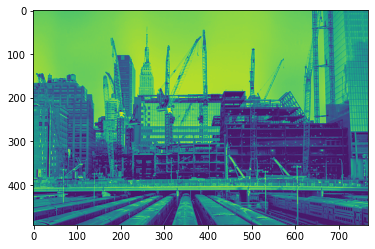

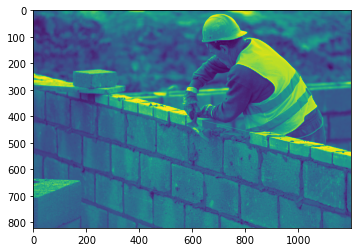

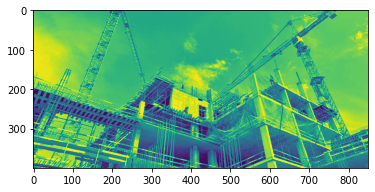

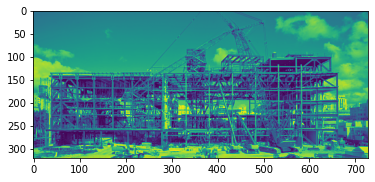

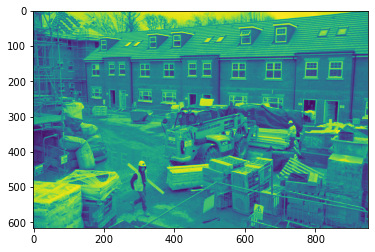

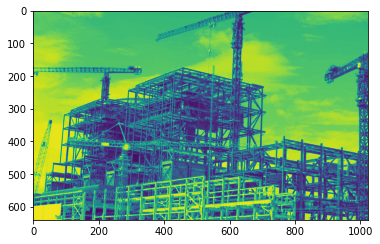

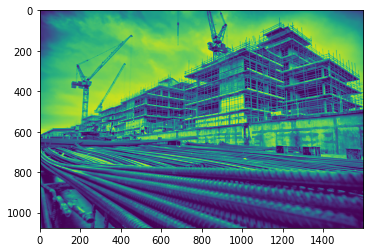

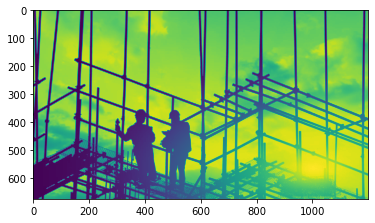

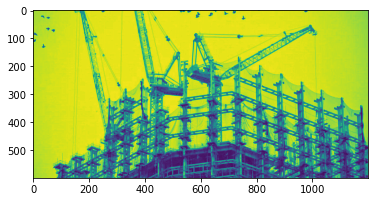

In [2]:
img_dir = "img"
if os.path.exists(img_dir):
    if os.listdir(img_dir) is []:
        print("No images!")
        exit(0)
    num_img = len(os.listdir(img_dir))
    for img in os.listdir(img_dir):
        if not img.endswith("jpg"):
            continue
        image_dir = os.path.join(img_dir, img)
        image = cv2.imread(image_dir)
        gray= cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        plt.imshow(gray)
        plt.show()
else:
    print("image folder not exists!")
    exit(0)

### The Keypoints:
The output of this part is a list of keypoints that represented by the x and y cooridnates.

For example, the 10 points of image ***3.jpg*** are:

In [3]:

#keypoints = list([(10.0, 10),  (16.0, 15.5), (15, 16), (1585, 16), (15, 1024), (100, 106), (150, 160), (715, 716), (315, 916), (815, 640)])

Then we can obtain the patches with these keypoints:


In [4]:
def getPatches(kps, img, size=32, num=500):
    res = torch.zeros(num, 1, size, size)
    if type(img) is np.ndarray:
        img = torch.from_numpy(img)
    h, w = img.shape      # note: for image, the x direction is the verticle, y-direction is the horizontal...
    for i in range(num):
        cx, cy = kps[i]
        cx, cy = int(cx), int(cy)
        dd = int(size/2)
        xmin, xmax = max(0, cx - dd), min(w, cx + dd ) 
        ymin, ymax = max(0, cy - dd), min(h, cy + dd ) 
        
        xmin_res, xmax_res = dd - min(dd,cx), dd + min(dd, w - cx)
        ymin_res, ymax_res = dd - min(dd,cy), dd + min(dd, h - cy)

        cropped_img = img[ymin: ymax, xmin: xmax]
        ch, cw = cropped_img.shape
        res[i, 0, ymin_res: ymin_res+ch, xmin_res: xmin_res+cw] =  cropped_img
        
    return res

### Let's plot these patches

In [5]:
all_patches_1 = []
all_keypoints_1 = []

all_patches_2 = []
all_keypoints_2 = []

for k in range(1,11):
    img = cv2.imread('img/' + str(k) + '.jpg')
    gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ## gray = img[:, :, 0]
    sift = cv2.xfeatures2d.SIFT_create(200)
    kp, des = sift.detectAndCompute(gray, None)
    keypoints = torch.tensor([cv2.KeyPoint_convert(kp)])

    if len(keypoints[0]) == 201:           
        keypoints = keypoints[0][:-1].view(1,200,2)
    all_keypoints_1.append(keypoints)
    patches_1 = getPatches(keypoints[0], gray, size=32, num=200)
    all_patches_1.append(patches_1)
    
    #plt.imshow(img),plt.show()
    
    corners = cv2.goodFeaturesToTrack(gray, maxCorners=200, qualityLevel = 0.01, minDistance = 10)
    
    for i in corners:
        x,y = i.ravel()
        cv2.circle(img, center = (x, y), radius = 5, color = 255, thickness = -1)
    
    gray_1 = np.float32(gray)
    dst = cv2.cornerHarris(gray_1,2,3,0.004)
    width, height = dst.shape
    dst = cv2.dilate(dst, None)
    ret, dst = cv2.threshold(dst, 0.01*dst.max(),255,0)
    dst = np.uint8(dst)
    
    ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)
    
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
    
    corners = cv2.cornerSubPix(gray,np.float32(centroids),(5,5),(-1,-1),criteria)
    corner_200 = corners[0:200]
    
    all_keypoints_2.append(corner_200)
    patches = getPatches(corner_200, gray, size=32, num=200)
    all_patches_2.append(patches)
    
    #res = np.hstack((centroids_200, corner_200))
    #res = np.int0(res)
    #img[res[:,1],res[:,0]] = [0,0,255]
    
    #cv2.imwrite('subpixel' + str(k) + '.png',img)
    
#for patch in patches:
#    im = patch[0].numpy()
#    plt.imshow(im)
#    plt.show()


### Save the patches with PyTorch
For each image, you can output the patches within one tensor. In above examples, tensor ***patches*** is the one that you should store in a list. And then save the list as a "SIFT.pth" file:

In [6]:
all_patches_1 = torch.stack(all_patches_1, dim=0)
all_patches_2 = torch.stack(all_patches_2, dim=0)

print(all_patches_2.shape)

kps_1 = torch.FloatTensor(all_keypoints_2)
kps_2 = torch.FloatTensor(all_keypoints_2)

print(kps_2.shape)

output_kps_1 = "SIFT.pth"
output_kps_2 = "Harris.pth"
output_dir_1 = "SIFT_patches.pth"         # modify it to SIFT.pth or Harris.pth
output_dir_2 = "Harris_patches.pth"
torch.save(all_patches_1, output_dir_1)
torch.save(all_patches_2, output_dir_2)
torch.save(kps_1, output_kps_1)
torch.save(kps_2, output_kps_2)

torch.Size([10, 200, 1, 32, 32])
torch.Size([10, 200, 2])


### Test with your saved patches

In [7]:
test_patches_1 = torch.load(output_dir_1)
test_patches_2 = torch.load(output_dir_2)

print(type(test_patches_1))
print(type(test_patches_2))

print(test_patches_1.shape)
print(test_patches_2.shape)
print(kps_1.shape)
print(kps_2.shape)

# your tensor for each should have size of [10, 200, 1, 32, 32];where 10 means 10 images (in the order 1-10), 200 means 200 points.

<class 'torch.Tensor'>
<class 'torch.Tensor'>
torch.Size([10, 200, 1, 32, 32])
torch.Size([10, 200, 1, 32, 32])
torch.Size([10, 200, 2])
torch.Size([10, 200, 2])
